<a href="https://colab.research.google.com/github/jadeacevedo/SVM-Optimization-Engine/blob/main/SVM_lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Data loading:


In [ ]:
# 1. Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Training images shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)
print("Image dimensions:", X_train[0].shape)
print("Unique labels:", np.unique(y_train))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)
Image dimensions: (28, 28)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
# 2. Convert images to vectors and normalize
X_train = X_train.reshape(X_train.shape[0], -1).astype("float32") / 255.0
X_test = X_test.reshape(X_test.shape[0], -1).astype("float32") / 255.0

# 3. Decrease dataset size to 10000
# Combine train and test to sample from full dataset
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

X_small, _, y_small, _ = train_test_split(
    X, y, train_size=10000, stratify=y, random_state=35
)

# Split into train/test again for evaluation
X_tr, X_te, y_tr, y_te = train_test_split(
    X_small, y_small, test_size=0.2, stratify=y_small, random_state=35
)

print("Reduced training images shape:", X_tr.shape)
print("Reduced training labels shape:", y_tr.shape)
print("Reduced test images shape:", X_te.shape)
print("Reduced test labels shape:", y_te.shape)

Reduced training images shape: (8000, 784)
Reduced training labels shape: (8000,)
Reduced test images shape: (2000, 784)
Reduced test labels shape: (2000,)


In [ ]:
# 5. Apply different feature scaling techniques
# Original normalized data (already normalized to [0,1])
X_tr_original = X_tr.copy()
X_te_original = X_te.copy()

# StandardScaler (zero mean, unit variance)
scaler_standard = StandardScaler()
X_tr_standard = scaler_standard.fit_transform(X_tr)
X_te_standard = scaler_standard.transform(X_te)

# MinMaxScaler (scaled to [0,1] range - similar to original but more robust)
scaler_minmax = MinMaxScaler()
X_tr_minmax = scaler_minmax.fit_transform(X_tr)
X_te_minmax = scaler_minmax.transform(X_te)

# RobustScaler (robust to outliers)
scaler_robust = RobustScaler()
X_tr_robust = scaler_robust.fit_transform(X_tr)
X_te_robust = scaler_robust.transform(X_te)

print("Scaling completed:")
print("Original data range: [{:.3f}, {:.3f}]".format(X_tr_original.min(), X_tr_original.max()))
print("StandardScaler range: [{:.3f}, {:.3f}]".format(X_tr_standard.min(), X_tr_standard.max()))
print("MinMaxScaler range: [{:.3f}, {:.3f}]".format(X_tr_minmax.min(), X_tr_minmax.max()))
print("RobustScaler range: [{:.3f}, {:.3f}]".format(X_tr_robust.min(), X_tr_robust.max()))

Scaling completed:
Original data range: [0.000, 1.000]
StandardScaler range: [-1.272, 89.437]
MinMaxScaler range: [0.000, 1.000]
RobustScaler range: [-0.672, 85.000]


In [ ]:
# 4. Define SVM models with different kernels and margins
models = {
    "linear_soft": SVC(kernel="linear", C=1, random_state=42),
    "linear_hard": SVC(kernel="linear", C=100, random_state=42),
    "rbf_soft": SVC(kernel="rbf", C=1, gamma="scale", random_state=42),
    "rbf_hard": SVC(kernel="rbf", C=100, gamma="scale", random_state=42),
    "poly_soft": SVC(kernel="poly", degree=3, C=1, gamma="scale", random_state=42),
    "poly_hard": SVC(kernel="poly", degree=3, C=100, gamma="scale", random_state=42),
    "sigmoid_soft": SVC(kernel="sigmoid", C=1, gamma="scale", random_state=42),
    "sigmoid_hard": SVC(kernel="sigmoid", C=100, gamma="scale", random_state=42),
}

In [ ]:
# Test models with different scalers
scalers = {
    "original": (X_tr_original, X_te_original),
    "standard": (X_tr_standard, X_te_standard),
    "minmax": (X_tr_minmax, X_te_minmax),
    "robust": (X_tr_robust, X_te_robust)
}

results = {}

for scaler_name, (X_tr_scaled, X_te_scaled) in scalers.items():
    print(f"\n=== Testing with {scaler_name.upper()} scaler ===")
    scaler_results = {}

    for model_name, model in models.items():
        print(f"Training {model_name}...")

        # Train the model
        model.fit(X_tr_scaled, y_tr)

        # Make predictions
        y_pred = model.predict(X_te_scaled)

        # Calculate accuracy
        accuracy = accuracy_score(y_te, y_pred)

        # Perform cross-validation
        cv_scores = cross_val_score(model, X_tr_scaled, y_tr, cv=5, scoring='accuracy')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

        scaler_results[model_name] = {
            'accuracy': accuracy,
            'cv_mean': cv_mean,
            'cv_std': cv_std,
            'model': model
        }

        print(f"  {model_name}: Test Accuracy = {accuracy:.4f}, CV Accuracy = {cv_mean:.4f} ± {cv_std:.4f}")

    results[scaler_name] = scaler_results


=== Testing with ORIGINAL scaler ===
Training linear_soft...
  linear_soft: Test Accuracy = 0.9200, CV Accuracy = 0.9073 ± 0.0038
Training linear_hard...
  linear_hard: Test Accuracy = 0.9180, CV Accuracy = 0.9066 ± 0.0037
Training rbf_soft...
  rbf_soft: Test Accuracy = 0.9590, CV Accuracy = 0.9525 ± 0.0064
Training rbf_hard...
  rbf_hard: Test Accuracy = 0.9640, CV Accuracy = 0.9591 ± 0.0035
Training poly_soft...
  poly_soft: Test Accuracy = 0.9495, CV Accuracy = 0.9435 ± 0.0053
Training poly_hard...
  poly_hard: Test Accuracy = 0.9580, CV Accuracy = 0.9496 ± 0.0039
Training sigmoid_soft...
  sigmoid_soft: Test Accuracy = 0.8280, CV Accuracy = 0.8289 ± 0.0077
Training sigmoid_hard...
  sigmoid_hard: Test Accuracy = 0.7625, CV Accuracy = 0.7624 ± 0.0072

=== Testing with STANDARD scaler ===
Training linear_soft...
  linear_soft: Test Accuracy = 0.9150, CV Accuracy = 0.9084 ± 0.0016
Training linear_hard...
  linear_hard: Test Accuracy = 0.9150, CV Accuracy = 0.9084 ± 0.0016
Training r

In [ ]:

def select_best_model(results):
    """
    Select best model based on cross-validation performance, not test accuracy
    """
    best_cv_score = -1
    best_config = {}

    for scaler_name, scaler_results in results.items():
        for model_name, result in scaler_results.items():
            cv_score = result['cv_mean']  # Use cross-validation mean
            cv_std = result['cv_std']


            if cv_score > best_cv_score:
                best_cv_score = cv_score
                best_config = {
                    'scaler': scaler_name,
                    'model_name': model_name,
                    'cv_mean': cv_score,
                    'cv_std': cv_std,
                    'test_accuracy': result['accuracy'],
                    'model': result['model']
                }

    return best_config


best_config = select_best_model(results)

# Debug1: Print all model performances
print("\n=== DETAILED PERFORMANCE ANALYSIS ===")
for scaler_name, scaler_results in results.items():
    print(f"\n{scaler_name.upper()} Scaler:")
    for model_name, result in scaler_results.items():
        print(f"  {model_name}: CV={result['cv_mean']:.4f} \u00b1 {result['cv_std']:.4f}, "
              f"Test={result['accuracy']:.4f}")

# Check if there's significant overfitting
print("\n=== OVERFITTING ANALYSIS ===")
for scaler_name, scaler_results in results.items():
    for model_name, result in scaler_results.items():
        overfit_gap = result['accuracy'] - result['cv_mean']
        if overfit_gap > 0.05:
            print(f"\u26a0\ufe0f  {model_name} with {scaler_name}: "
                  f"Overfitting gap = {overfit_gap:.4f}")
print("\n" + "="*50)
print("BEST MODEL CONFIGURATION:")
print(f"Scaler: {best_config['scaler']}")
print(f"Model: {best_config['model_name']}")
print(f"Test Accuracy: {best_config['test_accuracy']:.4f}")
print(f"Cross-Validation Accuracy: {best_config['cv_mean']:.4f} \u00b1 {best_config['cv_std']:.4f}")
print("="*50)


=== DETAILED PERFORMANCE ANALYSIS ===

ORIGINAL Scaler:
  linear_soft: CV=0.9073 ± 0.0038, Test=0.9200
  linear_hard: CV=0.9066 ± 0.0037, Test=0.9180
  rbf_soft: CV=0.9525 ± 0.0064, Test=0.9590
  rbf_hard: CV=0.9591 ± 0.0035, Test=0.9640
  poly_soft: CV=0.9435 ± 0.0053, Test=0.9495
  poly_hard: CV=0.9496 ± 0.0039, Test=0.9580
  sigmoid_soft: CV=0.8289 ± 0.0077, Test=0.8280
  sigmoid_hard: CV=0.7624 ± 0.0072, Test=0.7625

STANDARD Scaler:
  linear_soft: CV=0.9084 ± 0.0016, Test=0.9150
  linear_hard: CV=0.9084 ± 0.0016, Test=0.9150
  rbf_soft: CV=0.9314 ± 0.0047, Test=0.9395
  rbf_hard: CV=0.9380 ± 0.0028, Test=0.9460
  poly_soft: CV=0.8853 ± 0.0069, Test=0.9050
  poly_hard: CV=0.9477 ± 0.0043, Test=0.9575
  sigmoid_soft: CV=0.9044 ± 0.0035, Test=0.9020
  sigmoid_hard: CV=0.8435 ± 0.0048, Test=0.8465

MINMAX Scaler:
  linear_soft: CV=0.9070 ± 0.0034, Test=0.9205
  linear_hard: CV=0.9069 ± 0.0033, Test=0.9170
  rbf_soft: CV=0.9525 ± 0.0064, Test=0.9590
  rbf_hard: CV=0.9593 ± 0.0035, Tes

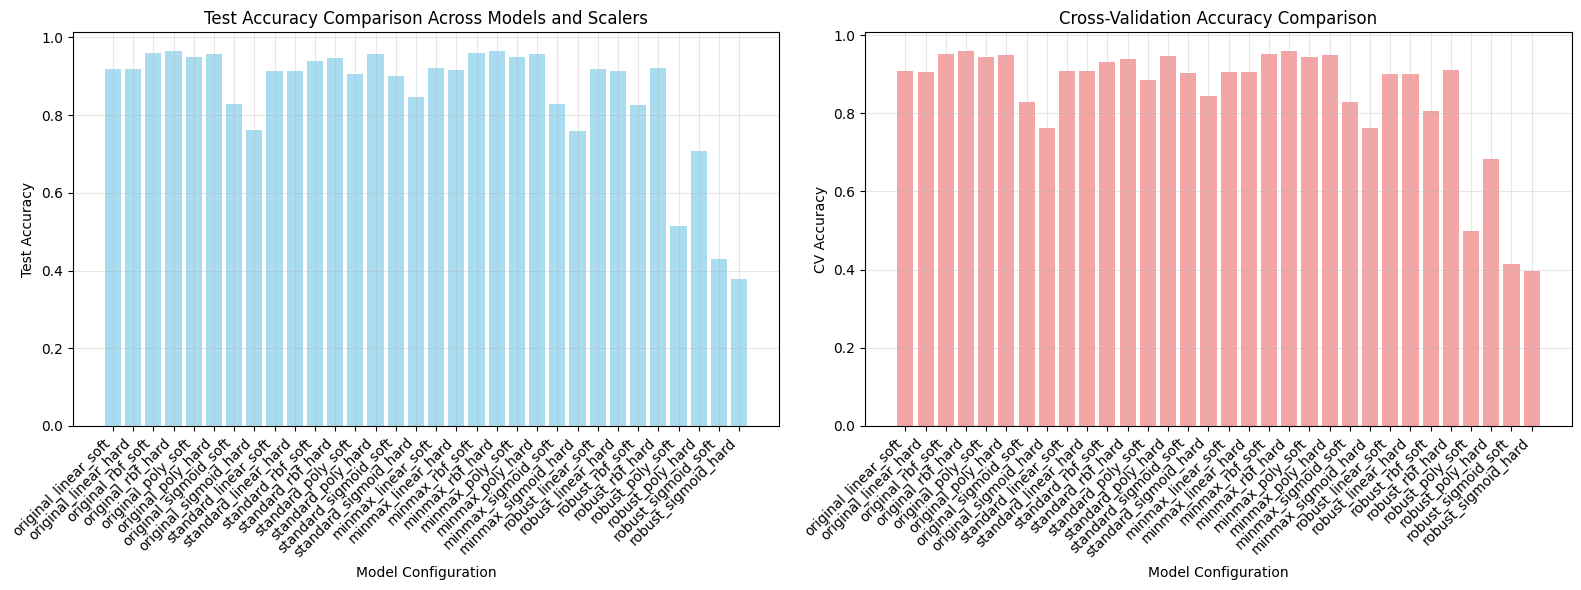

In [ ]:
# Visualize results comparison

comparison_data = []
for scaler_name, scaler_results in results.items():
    for model_name, result in scaler_results.items():
        comparison_data.append({
            'Scaler': scaler_name,
            'Model': model_name,
            'Test Accuracy': result['accuracy'],
            'CV Accuracy': result['cv_mean']
        })

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


scaler_model_names = [f"{row['Scaler']}_{row['Model']}" for row in comparison_data]
test_accuracies = [row['Test Accuracy'] for row in comparison_data]
cv_accuracies = [row['CV Accuracy'] for row in comparison_data]

x_pos = np.arange(len(scaler_model_names))

ax1.bar(x_pos, test_accuracies, alpha=0.7, color='skyblue')
ax1.set_title('Test Accuracy Comparison Across Models and Scalers')
ax1.set_xlabel('Model Configuration')
ax1.set_ylabel('Test Accuracy')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(scaler_model_names, rotation=45, ha='right')
ax1.grid(True, alpha=0.3)

ax2.bar(x_pos, cv_accuracies, alpha=0.7, color='lightcoral')
ax2.set_title('Cross-Validation Accuracy Comparison')
ax2.set_xlabel('Model Configuration')
ax2.set_ylabel('CV Accuracy')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(scaler_model_names, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Using best model: rbf_hard with minmax scaler
Final Test Accuracy: 0.9650


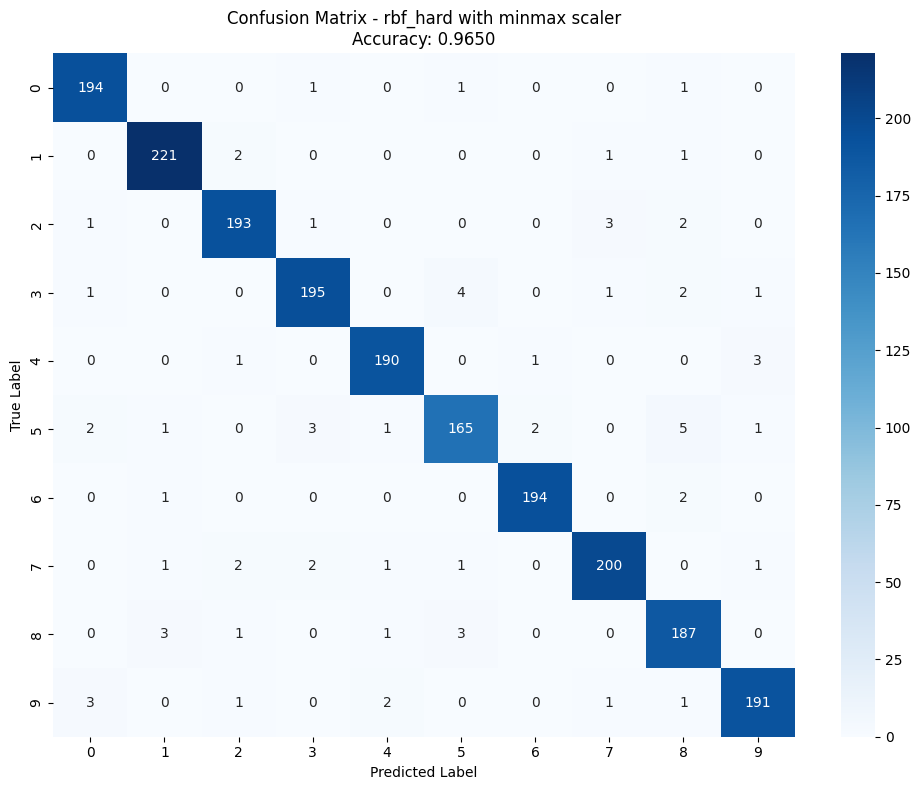

In [ ]:
# 6. Visualize confusion matrix for the best model
print(f"Using best model: {best_config['model_name']} with {best_config['scaler']} scaler")

X_tr_best = None
if best_config['scaler'] == 'original':
    X_tr_best = X_tr_original
    X_te_best = X_te_original
elif best_config['scaler'] == 'standard':
    X_tr_best = X_tr_standard
    X_te_best = X_te_standard
elif best_config['scaler'] == 'minmax':
    X_tr_best = X_tr_minmax
    X_te_best = X_te_minmax
else:  # robust
    X_tr_best = X_tr_robust
    X_te_best = X_te_robust


from sklearn.base import clone
best_model_template = models[best_config['model_name']]
best_model_for_viz = clone(best_model_template)
best_model_for_viz.fit(X_tr_best, y_tr)

# Make predictions with the correctly trained best model
y_pred_best = best_model_for_viz.predict(X_te_best)

# Calculate final accuracy
final_accuracy = accuracy_score(y_te, y_pred_best)
print(f"Final Test Accuracy: {final_accuracy:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_te, y_pred_best)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_te),
            yticklabels=np.unique(y_te))
plt.title(f'Confusion Matrix - {best_config["model_name"]} with {best_config["scaler"]} scaler\nAccuracy: {final_accuracy:.4f}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
# Summary of findings
print("\n" + "="*60)
print("SUMMARY OF FINDINGS")
print("="*60)

print("\n1. BEST OVERALL CONFIGURATION:")
print(f"   - Scaler: {best_config['scaler']}")
print(f"   - Model: {best_config['model_name']}")
print(f"   - Test Accuracy: {best_config['test_accuracy']:.4f}")
print(f"   - CV Accuracy: {best_config['cv_mean']:.4f} \u00b1 {best_config['cv_std']:.4f}")

print("\n2. PERFORMANCE BY KERNEL TYPE (Best for each):")
kernel_performance = {}
for scaler_name, scaler_results in results.items():
    for model_name, result in scaler_results.items():
        kernel = model_name.split('_')[0]
        if kernel not in kernel_performance or result['accuracy'] > kernel_performance[kernel]['accuracy']:
            kernel_performance[kernel] = {
                'accuracy': result['accuracy'],
                'model': model_name,
                'scaler': scaler_name
            }

for kernel, perf in kernel_performance.items():
    print(f"   - {kernel.upper()} kernel: {perf['accuracy']:.4f} "
          f"(using {perf['model']} with {perf['scaler']} scaler)")

print("\n3. PERFORMANCE BY SCALER TYPE (Best for each):")
scaler_performance = {}
for scaler_name, scaler_results in results.items():
    best_model_for_scaler = max(scaler_results.items(), key=lambda x: x[1]['accuracy'])
    scaler_performance[scaler_name] = {
        'accuracy': best_model_for_scaler[1]['accuracy'],
        'model': best_model_for_scaler[0]
    }

for scaler, perf in scaler_performance.items():
    print(f"   - {scaler.upper()} scaler: {perf['accuracy']:.4f} (using {perf['model']})")

print("\n4. HARD vs SOFT MARGIN COMPARISON:")
margin_comparison = {'soft': [], 'hard': []}
for scaler_name, scaler_results in results.items():
    for model_name, result in scaler_results.items():
        margin = 'hard' if 'hard' in model_name else 'soft'
        margin_comparison[margin].append(result['accuracy'])

print(f"   - Soft margin (C=1): Average accuracy = {np.mean(margin_comparison['soft']):.4f}")
print(f"   - Hard margin (C=100): Average accuracy = {np.mean(margin_comparison['hard']):.4f}")


SUMMARY OF FINDINGS

1. BEST OVERALL CONFIGURATION:
   - Scaler: minmax
   - Model: rbf_hard
   - Test Accuracy: 0.9650
   - CV Accuracy: 0.9593 ± 0.0035

2. PERFORMANCE BY KERNEL TYPE (Best for each):
   - LINEAR kernel: 0.9205 (using linear_soft with minmax scaler)
   - RBF kernel: 0.9650 (using rbf_hard with minmax scaler)
   - POLY kernel: 0.9580 (using poly_hard with original scaler)
   - SIGMOID kernel: 0.9020 (using sigmoid_soft with standard scaler)

3. PERFORMANCE BY SCALER TYPE (Best for each):
   - ORIGINAL scaler: 0.9640 (using rbf_hard)
   - STANDARD scaler: 0.9575 (using poly_hard)
   - MINMAX scaler: 0.9650 (using rbf_hard)
   - ROBUST scaler: 0.9205 (using rbf_hard)

4. HARD vs SOFT MARGIN COMPARISON:
   - Soft margin (C=1): Average accuracy = 0.8539
   - Hard margin (C=100): Average accuracy = 0.8618
